In [60]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train_df = pd.read_csv("Downloads/playground-series-s4e8/train.csv")
test_df = pd.read_csv("Downloads/playground-series-s4e8/test.csv")

In [76]:
submission=pd.read_csv("Downloads/playground-series-s4e8/sample_submission.csv")

In [3]:
train_df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [4]:
test_df.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,...,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,...,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [5]:
test_df.columns

Index(['id', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [6]:
train_df['class'].value_counts()

class
p    1705396
e    1411549
Name: count, dtype: int64

In [7]:
train_df['class'].isnull().sum()

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

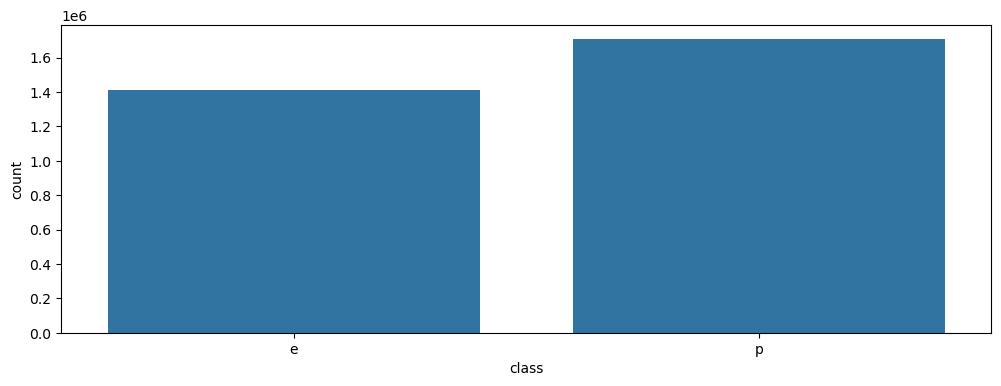

In [8]:
# Basic info
print(train_df.info())
print(train_df.describe())

# Missing values
print(train_df.isnull().sum())

# Distribution of the target variable
sns.countplot(x='class', data=train_df)
plt.show()

In [9]:
missing_threshold = 0.95

high_missing_columns = train_df.columns[train_df.isnull().mean() > missing_threshold]

train_df = train_df.drop(columns=high_missing_columns)
test_df = test_df.drop(columns=high_missing_columns)
target = 'class'

for column in train_df.columns:
    if train_df[column].isnull().any():      
        if train_df[column].dtype == 'object':
            mode_value = train_df[column].mode()[0]
            train_df[column].fillna(mode_value, inplace=True)
            test_df[column].fillna(mode_value, inplace=True)     
        else:
            median_value = train_df[column].median()
            train_df[column].fillna(median_value, inplace=True)
            test_df[column].fillna(median_value, inplace=True)

In [10]:
le = LabelEncoder()
train_df['class'] = le.fit_transform(train_df['class'])

In [11]:
train_df=train_df.drop(columns=['id'])
test_df=test_df.drop(columns=['id'])

In [12]:
cat_cols_train = train_df.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_df[cat_cols_train] = oe.fit_transform(train_df[cat_cols_train].astype(str))
test_df[cat_cols_train] = oe.transform(test_df[cat_cols_train].astype(str))

In [42]:
test_df.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,71.0,76.0,63.0,20.0,44.0,28.0,59.0,11.13,17.12,15.0,51.0,55.0,19.0,21.0,18.0,19.0,17.0,25.0,0.0
1,6.90,63.0,76.0,64.0,8.0,44.0,28.0,61.0,1.27,10.75,15.0,51.0,46.0,19.0,21.0,5.0,18.0,17.0,25.0,0.0
2,2.00,48.0,55.0,63.0,8.0,44.0,28.0,46.0,6.18,3.14,15.0,51.0,46.0,19.0,21.0,5.0,18.0,17.0,25.0,1.0
3,3.47,71.0,76.0,63.0,8.0,70.0,28.0,46.0,4.98,8.51,15.0,51.0,55.0,19.0,14.0,18.0,39.0,17.0,25.0,2.0
4,6.17,71.0,56.0,76.0,8.0,66.0,28.0,61.0,6.73,13.70,15.0,51.0,57.0,19.0,22.0,18.0,18.0,17.0,25.0,2.0


In [46]:
class_dir={'e':0, 'p':1}
train_class=train_df['class'].map(class_dir)

In [52]:
X = train_df.drop('class', axis=1)
y = train_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y)

In [56]:
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [66]:
model = XGBClassifier(                    
    alpha=0.1,                   
    subsample=0.8,     
    colsample_bytree=0.6,  
    objective='binary:logistic',
    max_depth=14,             
    min_child_weight=7,         
    gamma=1e-6,                
    random_state=42,                 
    n_estimators=100
    )

XGB = model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.49075
[1]	validation_0-logloss:0.35962
[2]	validation_0-logloss:0.26492
[3]	validation_0-logloss:0.19766
[4]	validation_0-logloss:0.15540
[5]	validation_0-logloss:0.12480
[6]	validation_0-logloss:0.10531
[7]	validation_0-logloss:0.09229
[8]	validation_0-logloss:0.08020
[9]	validation_0-logloss:0.07186
[10]	validation_0-logloss:0.06298
[11]	validation_0-logloss:0.05627
[12]	validation_0-logloss:0.05193
[13]	validation_0-logloss:0.04915
[14]	validation_0-logloss:0.04596
[15]	validation_0-logloss:0.04411
[16]	validation_0-logloss:0.04313
[17]	validation_0-logloss:0.04230
[18]	validation_0-logloss:0.04166
[19]	validation_0-logloss:0.04089
[20]	validation_0-logloss:0.04050
[21]	validation_0-logloss:0.04018
[22]	validation_0-logloss:0.03991
[23]	validation_0-logloss:0.03965
[24]	validation_0-logloss:0.03951
[25]	validation_0-logloss:0.03940
[26]	validation_0-logloss:0.03928
[27]	validation_0-logloss:0.03914
[28]	validation_0-logloss:0.03901
[29]	validation_0-loglos

In [70]:
y_pred = XGB.predict(X_test)

In [72]:
score = matthews_corrcoef(y_test, y_pred)
print('MCC:', score)

MCC: 0.9830112353210176


In [80]:
print("X_test shape:", X_test.shape)
print("test_df shape:", test_df.shape)

X_test shape: (623389, 20)
test_df shape: (2077964, 20)


In [82]:
y_pred = XGB.predict(test_df)
submission['class'] = y_pred
submission['class'] = submission['class'].map({0:'e', 1:'p'})
submission.to_csv('submission.csv', index=False)